# UMAP from random distance matrix

### Installing and loading libraries

In [1]:
import os
import pandas as pd
import sys
import numpy as np
from pandas.core.common import flatten
import pickle
import umap
from pathlib import Path
import datetime
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

In [2]:
from plot_functions import umap_2Dplot, mara_3Dplot, plotly_viz
from preprocessing_functions import pad_spectro, calc_zscore

### Setting constants

Setting project, input and output folders.

In [3]:
wd = os.getcwd()

DATA = os.path.join(os.path.sep, str(Path(wd).parents[0]), "data", "processed")
FIGURES = os.path.join(os.path.sep, str(Path(wd).parents[0]), "reports", "figures")

DF_DICT = {}
for dftype in ['full', 'reduced', 'balanced']:
    DF_DICT[dftype] = os.path.join(os.path.sep, DATA, "df_focal_"+dftype+".pkl")

# UMAP projection

## Preparation

### Choose dataset

In [4]:
dftype='reduced'
spec_df = pd.read_pickle(DF_DICT[dftype])
spec_df.shape

(6430, 29)

### Choose feature

In [5]:
specs = spec_df.spectrograms.copy()

# normalize feature
specs = [calc_zscore(x) for x in specs] 

# pad feature
maxlen= np.max([spec.shape[1] for spec in specs])
flattened_specs = [pad_spectro(spec, maxlen).flatten() for spec in specs]
data = np.asarray(flattened_specs)
data.shape

(6430, 5360)

## Run UMAP

In [6]:
random_distmat = np.random.rand(data.shape[0],data.shape[0])

for i in range(random_distmat.shape[0]):
    for j in range(i,random_distmat.shape[0]):
        random_distmat[i,j] = random_distmat[j,i]

for i in range(random_distmat.shape[0]):
    random_distmat[i,i] = 0

reducer = umap.UMAP(n_components=3, min_dist=0, metric='precomputed', random_state=2204)
embedding = reducer.fit_transform(random_distmat)

reducer = umap.UMAP(n_components=2, min_dist=0, metric='precomputed', random_state=2204)
embedding2D = reducer.fit_transform(random_distmat)

/home/mthomas/anaconda3/envs/meerkat_umap_env_3/lib/python3.7/site-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "
/home/mthomas/anaconda3/envs/meerkat_umap_env_3/lib/python3.7/site-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "


## Visualization

In [7]:
labels = spec_df.call_lable.values
pal="Set2"

### 2D Plots

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/UMAP_2D_plot_reduced_RANDOM_nolegend.jpg


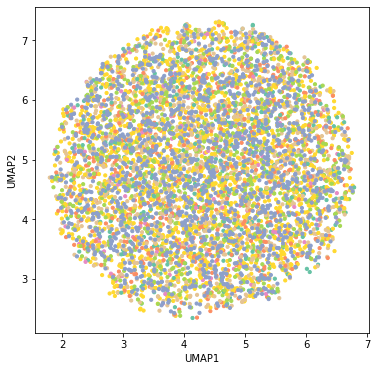

In [8]:
outname = os.path.join(os.path.sep, FIGURES, 'UMAP_2D_plot_'+dftype+'_RANDOM_nolegend.jpg')
print(outname)
umap_2Dplot(embedding2D[:,0], embedding2D[:,1], labels, pal, outname=outname, showlegend=False)

### 3D Plot

#### Matplotlib 

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/UMAP_3D_plot_reduced_RANDOM_nolegend.jpg


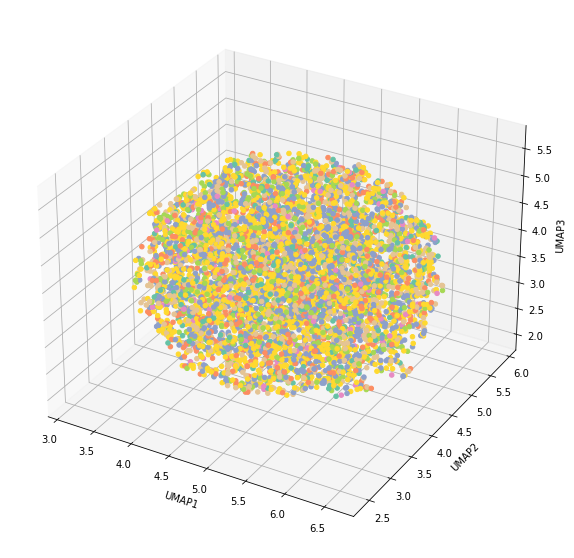

In [9]:
outname = os.path.join(os.path.sep, FIGURES, 'UMAP_3D_plot_'+dftype+'_RANDOM_nolegend.jpg')
print(outname)

mara_3Dplot(embedding[:,0],
            embedding[:,1],
            embedding[:,2],
            labels,
            pal,
            outname,
            showlegend=False)

## Save embedding

In [12]:
outname = os.path.join(os.path.sep, DATA,'basic_UMAP_'+dftype+'_default_params_RANDOM.csv')
np.savetxt(outname, embedding, delimiter=";")
print(outname)

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/data/processed/basic_UMAP_reduced_default_params_RANDOM.csv


# Embedding evaluation

Evaluate the embedding based on calltype labels of nearest neighbors.

In [10]:
from evaluation_functions import nn

In [11]:
nn_stats = nn(embedding, np.asarray(labels), k=5)

## Calculate metrics

In [14]:
print("Log final metric (unweighted):",nn_stats.get_S())
print("Abs final metric (unweighted):",nn_stats.get_Snorm())

Log final metric (unweighted): 14.291290012560816
Abs final metric (unweighted): -0.023702089315343646


/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/heatS_UMAP_reduced_RANDOM.png


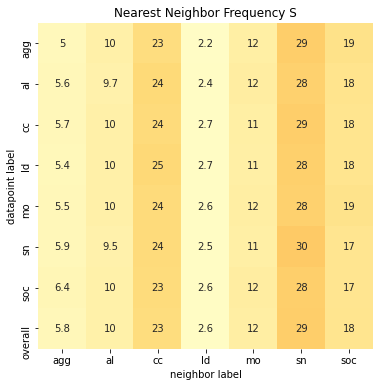

In [12]:
outname = os.path.join(os.path.sep, FIGURES, 'heatS_UMAP_'+dftype+'_RANDOM.png')
print(outname)

nn_stats.plot_heat_S(outname=outname)

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/heatSnorm_UMAP_reduced_RANDOM.png


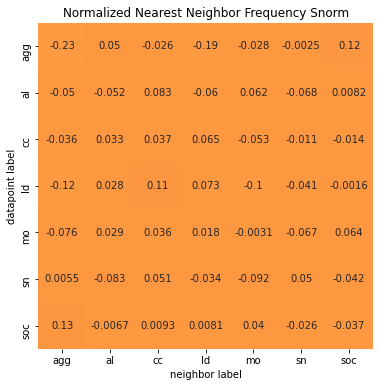

In [13]:
outname = os.path.join(os.path.sep, FIGURES, 'heatSnorm_UMAP_'+dftype+'_RANDOM.png')
print(outname)

nn_stats.plot_heat_Snorm(outname=outname)

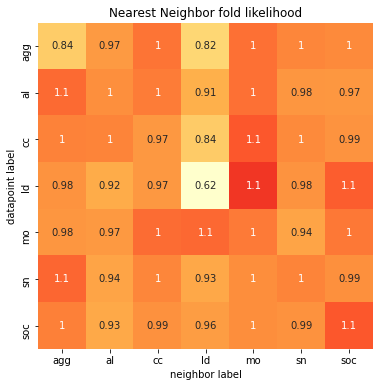

In [19]:
nn_stats.plot_heat_fold()

# Within vs. outside distances

In [20]:
from scipy.spatial.distance import pdist, squareform

In [21]:
labels = spec_df.call_lable.values
calltypes = sorted(list(set(labels)))

In [22]:
distmat_embedded = squareform(pdist(embedding, metric='euclidean'))

In [23]:
labels = np.asarray(labels)

self_dists={}
other_dists={}

for calltype in calltypes:
    x=distmat_embedded[np.where(labels==calltype)]
    x = np.transpose(x)  
    y = x[np.where(labels==calltype)]
   
    self_dists[calltype] = y[np.triu_indices(n=y.shape[0], m=y.shape[1],k = 1)]
    y = x[np.where(labels!=calltype)]
    other_dists[calltype] = y[np.triu_indices(n=y.shape[0], m=y.shape[1], k = 1)]

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/2021-06-09_distanceswithinwithout_reduced_RANDOM.jpg


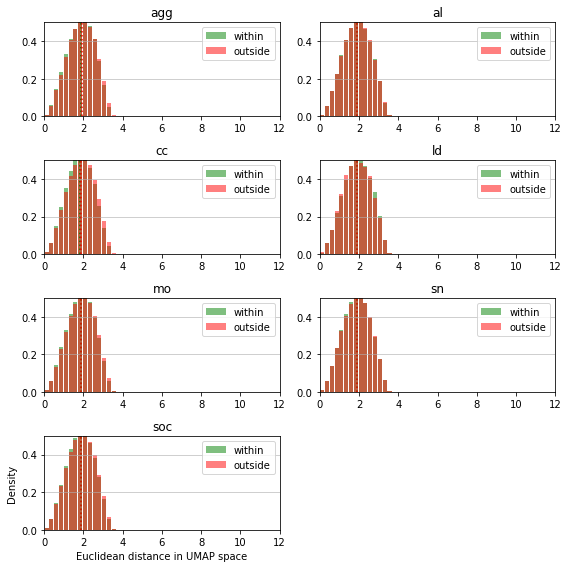

In [24]:
plt.figure(figsize=(8, 8))
i=1

xmin=0
xmax=12
nbins=50
    
for calltype in calltypes:
    
    plt.subplot(4, 2, i)
    n, bins, patches = plt.hist(x=self_dists[calltype], label="within", density=True,
                              bins=np.linspace(xmin, xmax, nbins), color='green',
                              alpha=0.5, rwidth=0.85)
    
    plt.vlines(x=np.mean(self_dists[calltype]),ymin=0,ymax=0.5,color='green', linestyles='dotted')

    n, bins, patches = plt.hist(x=other_dists[calltype], label="outside", density=True,
                              bins=np.linspace(xmin, xmax, nbins), color='red',
                              alpha=0.5, rwidth=0.85)
  
    plt.vlines(x=np.mean(other_dists[calltype]),ymin=0,ymax=0.5,color='red', linestyles='dotted')
  
    s, pval = scipy.stats.ttest_ind(self_dists[calltype],other_dists[calltype])

    if pval<0.01:
        pval = "p<0.01"
    else:
        pval = "p="+str(round(pval,2))

    plt.legend()
    plt.grid(axis='y', alpha=0.75)
    #plt.title(calltype+" ("+pval+")")
    plt.title(calltype)
    plt.xlim(xmin,xmax)
    plt.ylim(0, 0.5)
    if i==len(calltypes):      
        plt.ylabel('Density')
        plt.xlabel('Euclidean distance in UMAP space')

    i=i+1

plt.tight_layout()
outname=os.path.join(os.path.sep, FIGURES, datetime.datetime.today().strftime('%Y-%m-%d')+'_distanceswithinwithout_'+dftype+'_RANDOM.jpg')
print(outname)
plt.savefig(outname, facecolor="white")

## Silhouette Plot

In [25]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [26]:
umap_df = spec_df

In [27]:
embedding.shape

(6430, 3)

/home/mthomas/Documents/MPI_work/projects/meerkat/meerkat_umap_pv/reports/figures/2021-06-09_UMAP_silhouette_reduced_RANDOM.jpg


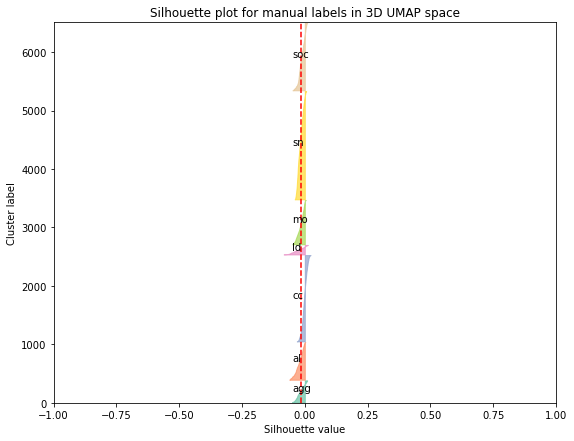

In [28]:
labels = umap_df.call_lable
labeltypes = sorted(list(set(labels)))
n_clusters = len(labeltypes)

# Create a subplot with 1 row and 2 columns
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(9, 7)

ax1.set_xlim([-1, 1])

ax1.set_ylim([0, embedding.shape[0] + (n_clusters + 1) * 10])
#cluster_labels = umap_df['HDBSCAN']
cluster_labels = labels
silhouette_avg = silhouette_score(embedding, cluster_labels)


# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(embedding, cluster_labels)
y_lower = 10

pal = sns.color_palette("Set2", n_colors=len(labeltypes))
color_dict = dict(zip(labeltypes, pal))


for i, cluster_label in enumerate(labeltypes):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == cluster_label]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                    0, ith_cluster_silhouette_values,
                    facecolor=color_dict[cluster_label], edgecolor=color_dict[cluster_label], alpha=0.7)
    
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, cluster_label)

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("Silhouette plot for manual labels in 3D UMAP space")
ax1.set_xlabel("Silhouette value")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

outname = os.path.join(os.path.sep, FIGURES, datetime.datetime.today().strftime('%Y-%m-%d')+'_UMAP_silhouette_'+dftype+'_RANDOM.jpg')
print(outname)
plt.savefig(outname, facecolor="white")

In [49]:
# Original % with pos scores
sample_silhouette_values = silhouette_samples(data, cluster_labels)
print("Original: ", sample_silhouette_values[sample_silhouette_values>0].shape[0]/sample_silhouette_values.shape[0])

original:  0.5376360808709175


In [51]:
# UMAP % with pos scores
sample_silhouette_values = silhouette_samples(embedding, cluster_labels)
print("Embedding: ",sample_silhouette_values[sample_silhouette_values>0].shape[0]/sample_silhouette_values.shape[0])

Embedding:  0.15349922239502334


Sil scores and % with negative scores as unweighted average per class

In [31]:
labeltypes = sorted(list(set(labels)))
n_clusters = len(labeltypes)

prop_pos_dict_UMAP = {}
sil_UMAP ={}

#cluster_labels = umap_df['HDBSCAN']
cluster_labels = labels
silhouette_avg = silhouette_score(embedding, cluster_labels)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(embedding, cluster_labels)


for i, cluster_label in enumerate(labeltypes):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == cluster_label]
    pos_vals = ith_cluster_silhouette_values[ith_cluster_silhouette_values>0]
    print(cluster_label, ": ", pos_vals.shape[0]/ith_cluster_silhouette_values.shape[0]*100)
    prop_pos_dict_UMAP[cluster_label] = pos_vals.shape[0]/ith_cluster_silhouette_values.shape[0]*100
    sil_UMAP[cluster_label] = np.mean(ith_cluster_silhouette_values)


agg :  17.599999999999998
al :  1.08359133126935
cc :  39.26878808395396
ld :  15.853658536585366
mo :  3.557312252964427
sn :  4.905660377358491
soc :  16.464471403812826


# Graph from embedding evaluation

Resource: https://en.it1352.com/article/d096c1eadbb84c19b038eb9648153346.html

In [32]:
embedding_filename = 'basic_UMAP_'+dftype+'_default_params_RANDOM.csv'
embedding = np.loadtxt(os.path.join(os.path.sep, DATA, embedding_filename),delimiter=";")

In [40]:
labels = spec_df.call_lable.values

array(['al', 'al', 'al', ..., 'cc', 'cc', 'cc'], dtype=object)

In [42]:
nn_stats = nn(embedding, labels, k=5)
stats_tab_norm = nn_stats.get_statstabnorm()
#stats_tab_norm

In [34]:
import networkx as nx
import string
import pygraphviz

In [43]:
sim_mat = np.asarray(stats_tab_norm).copy()

for i in range(sim_mat.shape[0]):
    for j in range(i,sim_mat.shape[0]):
        if i!=j:
            sim_mat[i,j] = np.mean((sim_mat[i,j], sim_mat[j,i]))
            sim_mat[j,i] = sim_mat[i,j]
        else:
            sim_mat[i,j] = 0

In [44]:
pd.DataFrame(sim_mat)

,0,1,2,3,4,5,6
0,0.000000,0.011113,0.037284,-0.159628,0.013290,0.047039,0.016973
1,0.011113,0.000000,0.027041,-0.125894,0.005565,-0.058406,-0.073700
2,0.037284,0.027041,0.000000,-0.143040,0.089292,0.008768,-0.019062
3,-0.159628,-0.125894,-0.143040,0.000000,0.130059,-0.063308,0.020361
4,0.013290,0.005565,0.089292,0.130059,0.000000,-0.043832,0.019589
5,0.047039,-0.058406,0.008768,-0.063308,-0.043832,0.000000,-0.015338
6,0.016973,-0.073700,-0.019062,0.020361,0.019589,-0.015338,0.000000


In [45]:
dist_mat = sim_mat*(-1)
dist_mat = np.interp(dist_mat, (dist_mat.min(), dist_mat.max()), (1, 10))

In [46]:
for i in range(dist_mat.shape[0]):
    dist_mat[i,i] = 0

In [47]:
pd.DataFrame(dist_mat, columns=calltypes, index=calltypes)

,agg,al,cc,ld,mo,sn,soc
agg,0.000000,4.695406,3.882331,10.000000,4.627773,3.579275,4.513369
al,4.695406,0.000000,4.200558,8.951954,4.867796,6.855218,7.330392
cc,3.882331,4.200558,0.000000,9.484628,2.266562,4.768269,5.632880
ld,10.000000,8.951954,9.484628,0.000000,1.000000,7.007514,4.408088
mo,4.627773,4.867796,2.266562,1.000000,0.000000,6.402451,4.432092
sn,3.579275,6.855218,4.768269,7.007514,6.402451,0.000000,5.517193
soc,4.513369,7.330392,5.632880,4.408088,4.432092,5.517193,0.000000


In [48]:
dt = [('len', float)]
A = dist_mat

A = A.view(dt)

G = nx.from_numpy_matrix(A)
G = nx.relabel_nodes(G, dict(zip(range(len(G.nodes())),calltypes))) 

G = nx.drawing.nx_agraph.to_agraph(G)

G.node_attr.update(color="#bec1d4", style="filled", shape='circle', fontsize='20')
G.edge_attr.update(color="blue", width="2.0")

G.draw(os.path.join(os.path.sep,FIGURES,'simgraph_RANDOM.png'), format='png', prog='neato')